In [24]:
import pickle
import pandas as pd
import torch
import io

from explore import LayerwiseQuantizationProblem, QuantizationModel

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)


with open('exploration_20_25_v2.pkl', 'rb') as f:
    d = CPU_Unpickler(f).load()

type(d)

pymoo.core.result.Result

In [25]:
from torchvision import models
from pytorch_quantization import nn as quant_nn

m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
layer_names = []

for name, module in m.named_modules():
    if isinstance(module, quant_nn.TensorQuantizer):
        layer_names.append(name)


In [26]:
import numpy as np

pop = d.pop

df_data = np.empty( (0, 111) )
for h in d.history:
    for ind in h.opt:
        l = np.concatenate( (ind.get("F"), ind.get("X")) )
        l = np.expand_dims(l, axis=0)
        df_data = np.concatenate( (df_data, l), axis=0)

print(df_data.shape)
df = pd.DataFrame(df_data, columns=["Acc", "Bits"] + layer_names)

print(len(df))

df['Acc'] = -df['Acc']
df.sort_values('Bits')

(319, 111)
319


,Acc,Bits,conv1._input_quantizer,conv1._weight_quantizer,layer1.0.conv1._input_quantizer,layer1.0.conv1._weight_quantizer,layer1.0.conv2._input_quantizer,layer1.0.conv2._weight_quantizer,layer1.0.conv3._input_quantizer,layer1.0.conv3._weight_quantizer,...,layer4.1.conv3._weight_quantizer,layer4.2.conv1._input_quantizer,layer4.2.conv1._weight_quantizer,layer4.2.conv2._input_quantizer,layer4.2.conv2._weight_quantizer,layer4.2.conv3._input_quantizer,layer4.2.conv3._weight_quantizer,avgpool._input_quantizer,fc._input_quantizer,fc._weight_quantizer
300,0.754883,829.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
298,0.749512,831.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
296,0.751465,832.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
220,0.759277,836.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
317,0.759277,836.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
279,0.759277,836.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
260,0.759277,836.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
240,0.759277,836.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,4.0,10.0,4.0,9.0,7.0,8.0,3.0,7.0,4.0,12.0
182,0.741211,843.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,5.0,10.0,4.0,9.0,7.0,9.0,3.0,9.0,4.0,12.0
199,0.756348,843.0,6.0,9.0,9.0,10.0,4.0,10.0,7.0,10.0,...,5.0,10.0,4.0,9.0,7.0,8.0,3.0,9.0,4.0,12.0


<AxesSubplot:xlabel='Acc', ylabel='Bits'>

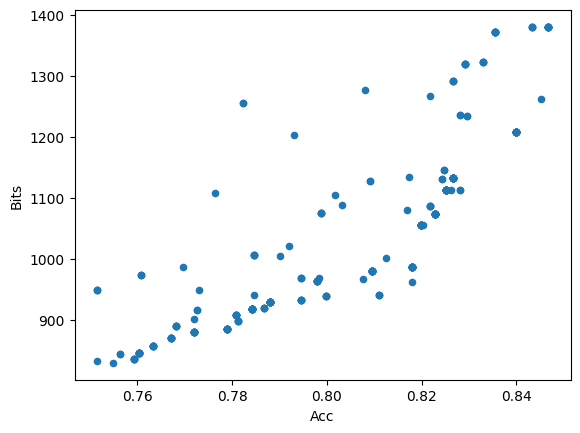

In [27]:
df_sel = df.where(df['Acc'] > 0.75)
df_sel.plot(x='Acc', y='Bits', kind='scatter')

<AxesSubplot:>

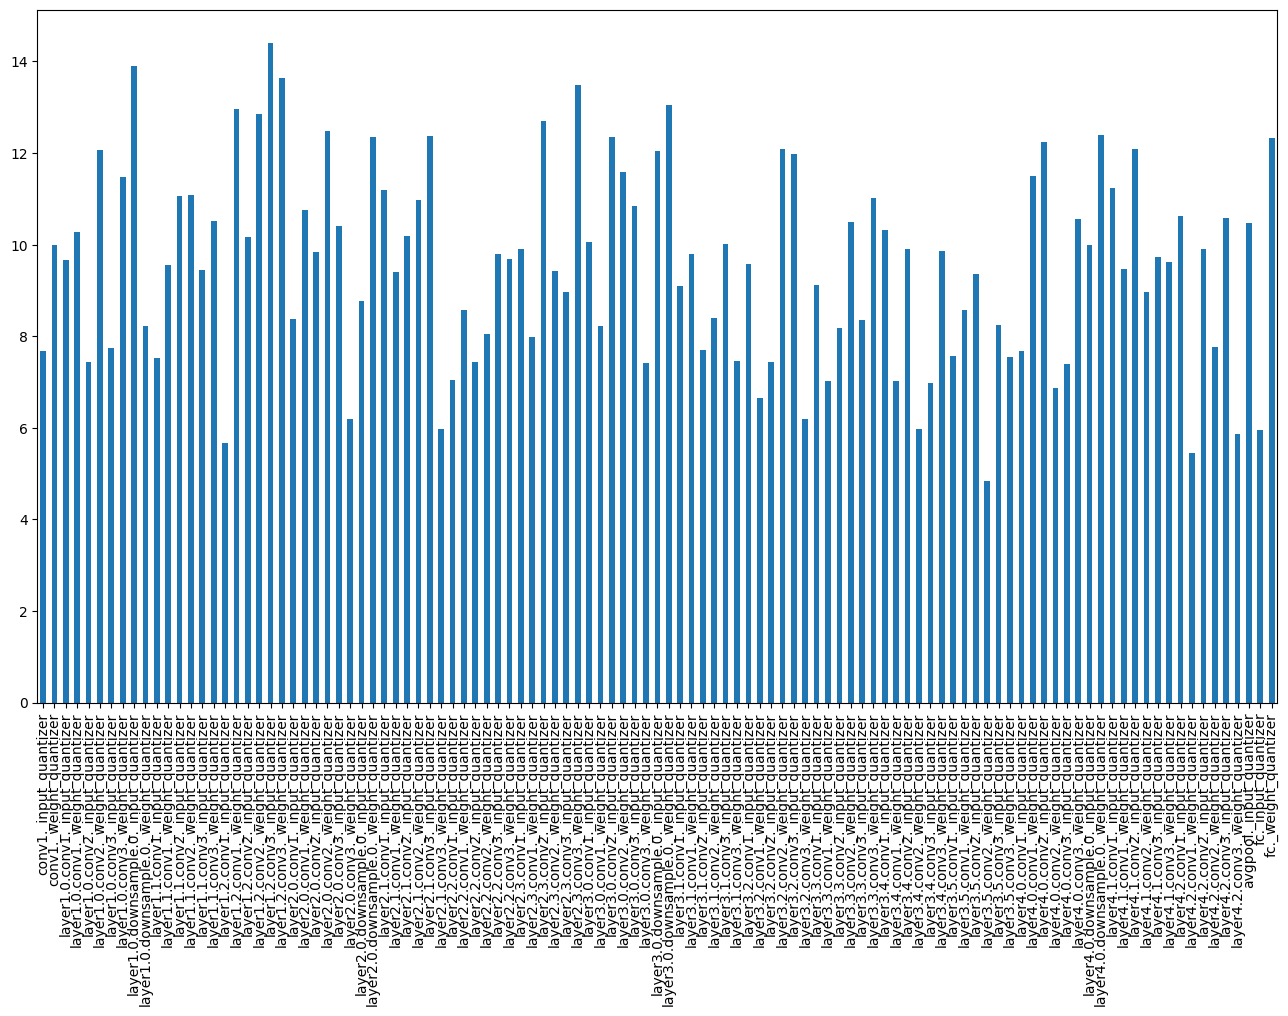

In [28]:
df_means = df_sel.mean().iloc[2:]
df_means.plot(kind='bar', figsize=(16,9))

In [29]:
pd.set_option('display.max_rows', None)
print(df_means.sort_values())

# print(layer_names)

layer3.5.conv2._weight_quantizer            4.827815
layer4.2.conv1._weight_quantizer            5.450331
layer1.2.conv1._input_quantizer             5.662252
layer4.2.conv3._weight_quantizer            5.870861
fc._input_quantizer                         5.943709
layer3.4.conv2._weight_quantizer            5.963576
layer2.1.conv3._weight_quantizer            5.983444
layer2.0.conv3._weight_quantizer            6.185430
layer3.2.conv3._weight_quantizer            6.198675
layer3.2.conv1._weight_quantizer            6.642384
layer4.0.conv2._weight_quantizer            6.877483
layer3.4.conv3._input_quantizer             6.973510
layer3.4.conv1._weight_quantizer            7.013245
layer3.3.conv1._weight_quantizer            7.029801
layer2.2.conv1._input_quantizer             7.033113
layer4.0.conv3._input_quantizer             7.397351
layer3.0.conv3._weight_quantizer            7.413907
layer1.0.conv2._input_quantizer             7.433775
layer3.2.conv2._input_quantizer             7.

In [30]:
# Todo, pick one optimal solution and visualize the distribution of weights and activations in each conv2d 
print(['downsample' in name for name in layer_names])

[False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
